In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../../experiments/sou-multisin10/"

# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

# make tables dir
if not os.path.exists(BASE_DIR + "tables"):
    os.makedirs(BASE_DIR + "tables")

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

profiles= ["multisin10-3x64-s005", "multisin10-3x64-s05", "multisin10-3x64-s5", "multisin10-3x64-sl"]

names = [configs[p]["NAME"] for p in profiles]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(profiles))]

reruns = 10

In [5]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x10917df10>)

In [6]:


train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    train_stats[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/train_stats_{run}.json", "r") as f:
            train_stats[name].append(json.load(f))

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    results[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/results_{run}.json", "r") as f:
            results[name].append(json.load(f))

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    posterior_samples[name] = []
    # Load posterior samples
    for run in range(1, reruns+1):
        train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_{run}.npy")
        test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_{run}.npy")
        test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_{run}.npy")
        test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_{run}.npy")

        posterior_samples[name].append({
            "train": train,
            "test": test,
            "test_in_domain": test_in_domain,
            "test_out_domain": test_out_domain
        })

In [8]:
[results["multisin10-3x64-s05"][i]["in_domain"]["error"]["rmse"] for i in range(reruns)]

[0.6657229661941528,
 0.6761569380760193,
 0.7020301818847656,
 0.6757566928863525,
 0.6932742595672607,
 0.6835903525352478,
 0.68180251121521,
 0.67784583568573,
 0.6795740723609924,
 0.6620352864265442]

In [9]:
#Generate table for Train
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/train.csv")

print("TRAIN")
display(table)
print()

# Generate table for in_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/in_domain.csv")

print("IN DOMAIN")
display(table)
print()


# Generate table for out_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/out_domain.csv")

print("OUT DOMAIN")
display(table)
print()


TRAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
multisin10-3x64-s005,0.05±0.0,0.27±0.01,0.21±0.01,-4.72±0.73
multisin10-3x64-s05,0.5±0.0,0.56±0.01,0.45±0.01,-0.85±0.02
multisin10-3x64-s5,5.0±0.0,1.21±0.04,0.94±0.03,-2.6±0.01
multisin10-3x64-sl,0.69±0.05,0.61±0.02,0.48±0.01,-0.96±0.03



IN DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
multisin10-3x64-s005,0.05±0.0,1.11±0.06,0.87±0.04,-94.28±8.36
multisin10-3x64-s05,0.5±0.0,0.68±0.02,0.54±0.02,-1.05±0.04
multisin10-3x64-s5,5.0±0.0,1.28±0.04,0.99±0.03,-2.6±0.01
multisin10-3x64-sl,0.69±0.05,0.69±0.02,0.54±0.01,-1.05±0.02



OUT DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
multisin10-3x64-s005,0.05±0.0,11.87±0.32,9.47±0.24,-1752.44±94.81
multisin10-3x64-s05,0.5±0.0,11.95±0.4,9.56±0.32,-33.57±4.89
multisin10-3x64-s5,5.0±0.0,9.47±0.12,7.61±0.1,-3.85±0.04
multisin10-3x64-sl,0.69±0.05,11.66±0.29,9.32±0.25,-17.36±6.97


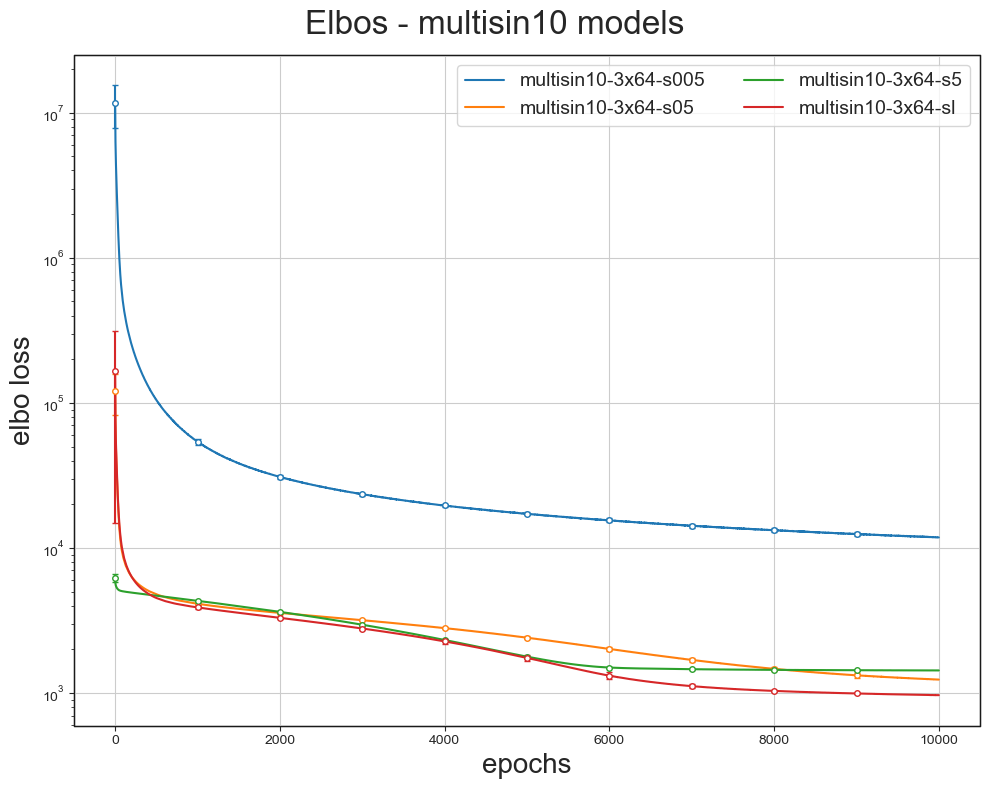

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Elbos - multisin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = [train_stats[name][i]["elbos"] for i in range(reruns)]
    means = np.mean(elbos, axis=0)
    stds = np.std(elbos, axis=0)
    ax.plot(means, label=name, color=colors[i])

    err_range = list(range(0, len(means), 1000))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)

ax.set_yscale("log", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend(fontsize=14, ncol=2)
ax.set_xlabel("epochs", fontsize=20)
ax.set_ylabel("elbo loss", fontsize=20)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg", dpi=300)
plt.show()

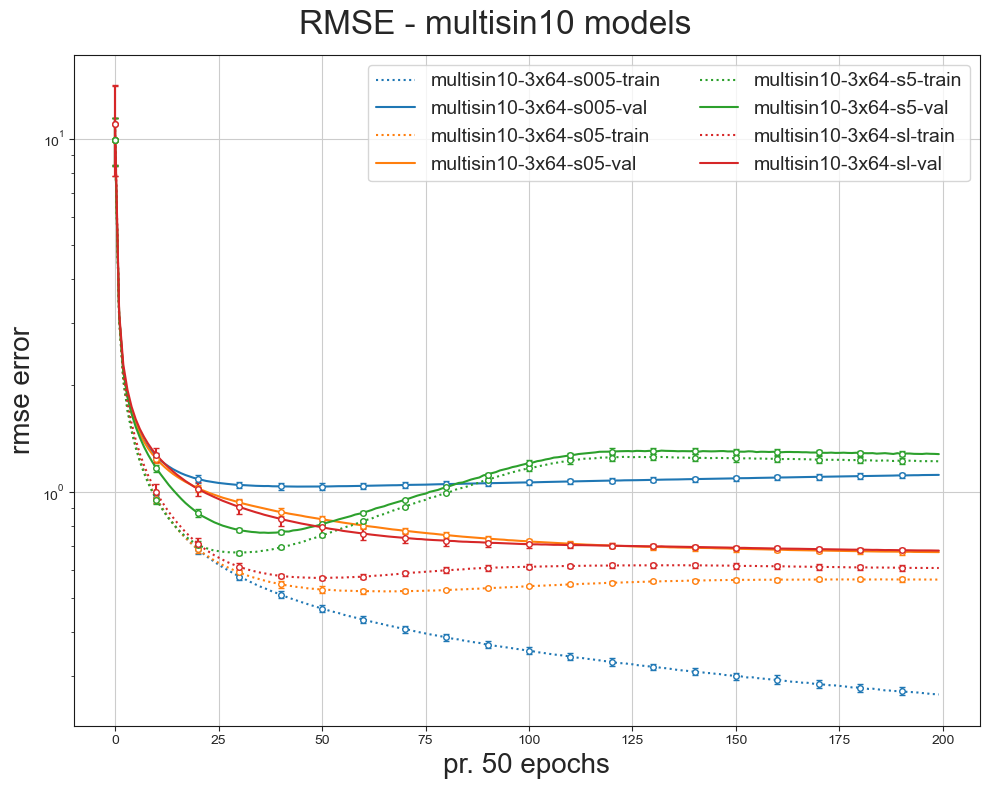

In [26]:
#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("RMSE - multisin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_rmse"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.1, color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)


    ve = [train_stats[name][i]["val_rmse"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i], hatch='//')
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)

    ax.set_yscale('log')
ax.legend( fontsize=14, ncol=2)
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("rmse error", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse.svg", format="svg", dpi=300)
plt.show()

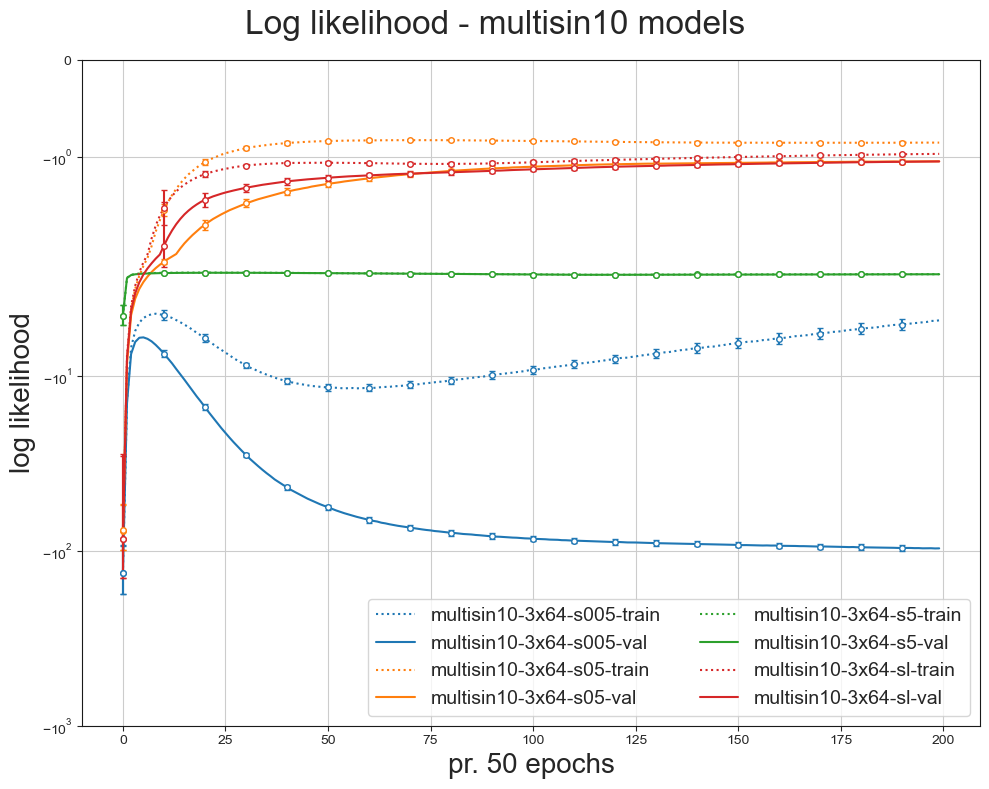

In [27]:
#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Log likelihood - multisin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_ll"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)

    ve = [train_stats[name][i]["val_ll"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)
plt.ylim(bottom=-1000, top=0)
ax.legend( fontsize=14, ncol=2, loc="lower right")
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("log likelihood", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll.svg", format="svg", dpi=300)
plt.show()

In [12]:
train_rmse = [results[k]["train"]["error"]["rmse"] for k in names]
in_domain_rmse = [results[k]["in_domain"]["error"]["rmse"] for k in names]
out_domain_rmse = [results[k]["out_domain"]["error"]["rmse"] for k in names]

metrics = [("train_rmse", train_rmse), ("in_domain_rmse", in_domain_rmse), ("out_domain_rmse", out_domain_rmse)]



fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    #annotate each point
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("RMSE")
    ax[i].set_ylim(bottom=0.0)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)
    ax[i].grid(False)

plt.show()



train_mae = [results[k]["train"]["error"]["mae"] for k in names]
in_domain_mae = [results[k]["in_domain"]["error"]["mae"] for k in names]
out_domain_mae = [results[k]["out_domain"]["error"]["mae"] for k in names]

metrics = [("train_mae", train_mae), ("in_domain_mae", in_domain_mae), ("out_domain_mae", out_domain_mae)]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("MAE")
    ax[i].set_ylim(bottom=0.0)
    #set x labels to be slanted
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)

plt.show()

TypeError: list indices must be integers or slices, not str

In [ ]:
run = 1

name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [ ]:
data_samples

{'train_x': array([[ 0.10111914,  0.59942734,  0.8757908 , ..., -0.12627056,
         -1.2307777 , -1.7559822 ],
        [-0.82247317, -1.9920797 , -1.0743955 , ...,  0.09512219,
         -0.48497397,  0.48244318],
        [-0.31112495, -1.4061391 , -0.9059853 , ...,  0.5401983 ,
          0.22423759,  0.7231136 ],
        ...,
        [ 0.36448008, -0.08925682, -1.7424535 , ...,  0.77071244,
         -0.98118585, -1.2705014 ],
        [-1.1911093 , -1.3108561 ,  0.78218204, ...,  1.5261176 ,
         -1.8181038 , -1.9492189 ],
        [-0.07866658, -0.4814255 ,  1.5604229 , ...,  1.068271  ,
          1.7413484 , -0.03321254]], dtype=float32),
 'test_in_domain_x': array([[ 0.60711366,  0.54977775, -0.10806876, ..., -1.3402047 ,
          0.08701517,  1.595384  ],
        [ 0.2598087 ,  0.42272887, -0.50971186, ...,  1.1693558 ,
          0.2043035 ,  0.90268177],
        [-0.8823611 ,  0.27269322,  1.7310419 , ..., -0.81310624,
         -0.40559658, -0.5039171 ],
        ...,
        

In [ ]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1][0]["train"].shape)

(1000, 10)
(1000, 1000)
(1000, 1000)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

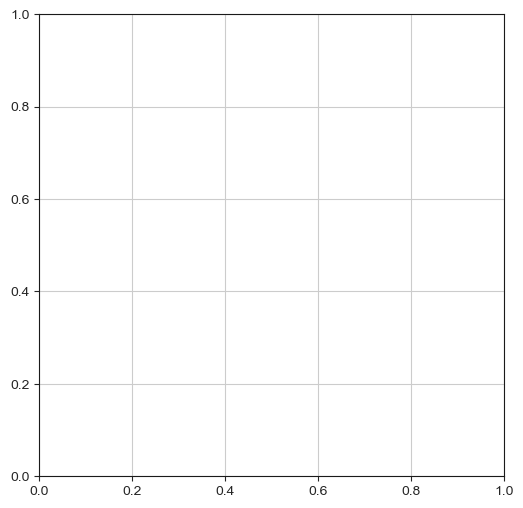

In [ ]:
# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p][run-1]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

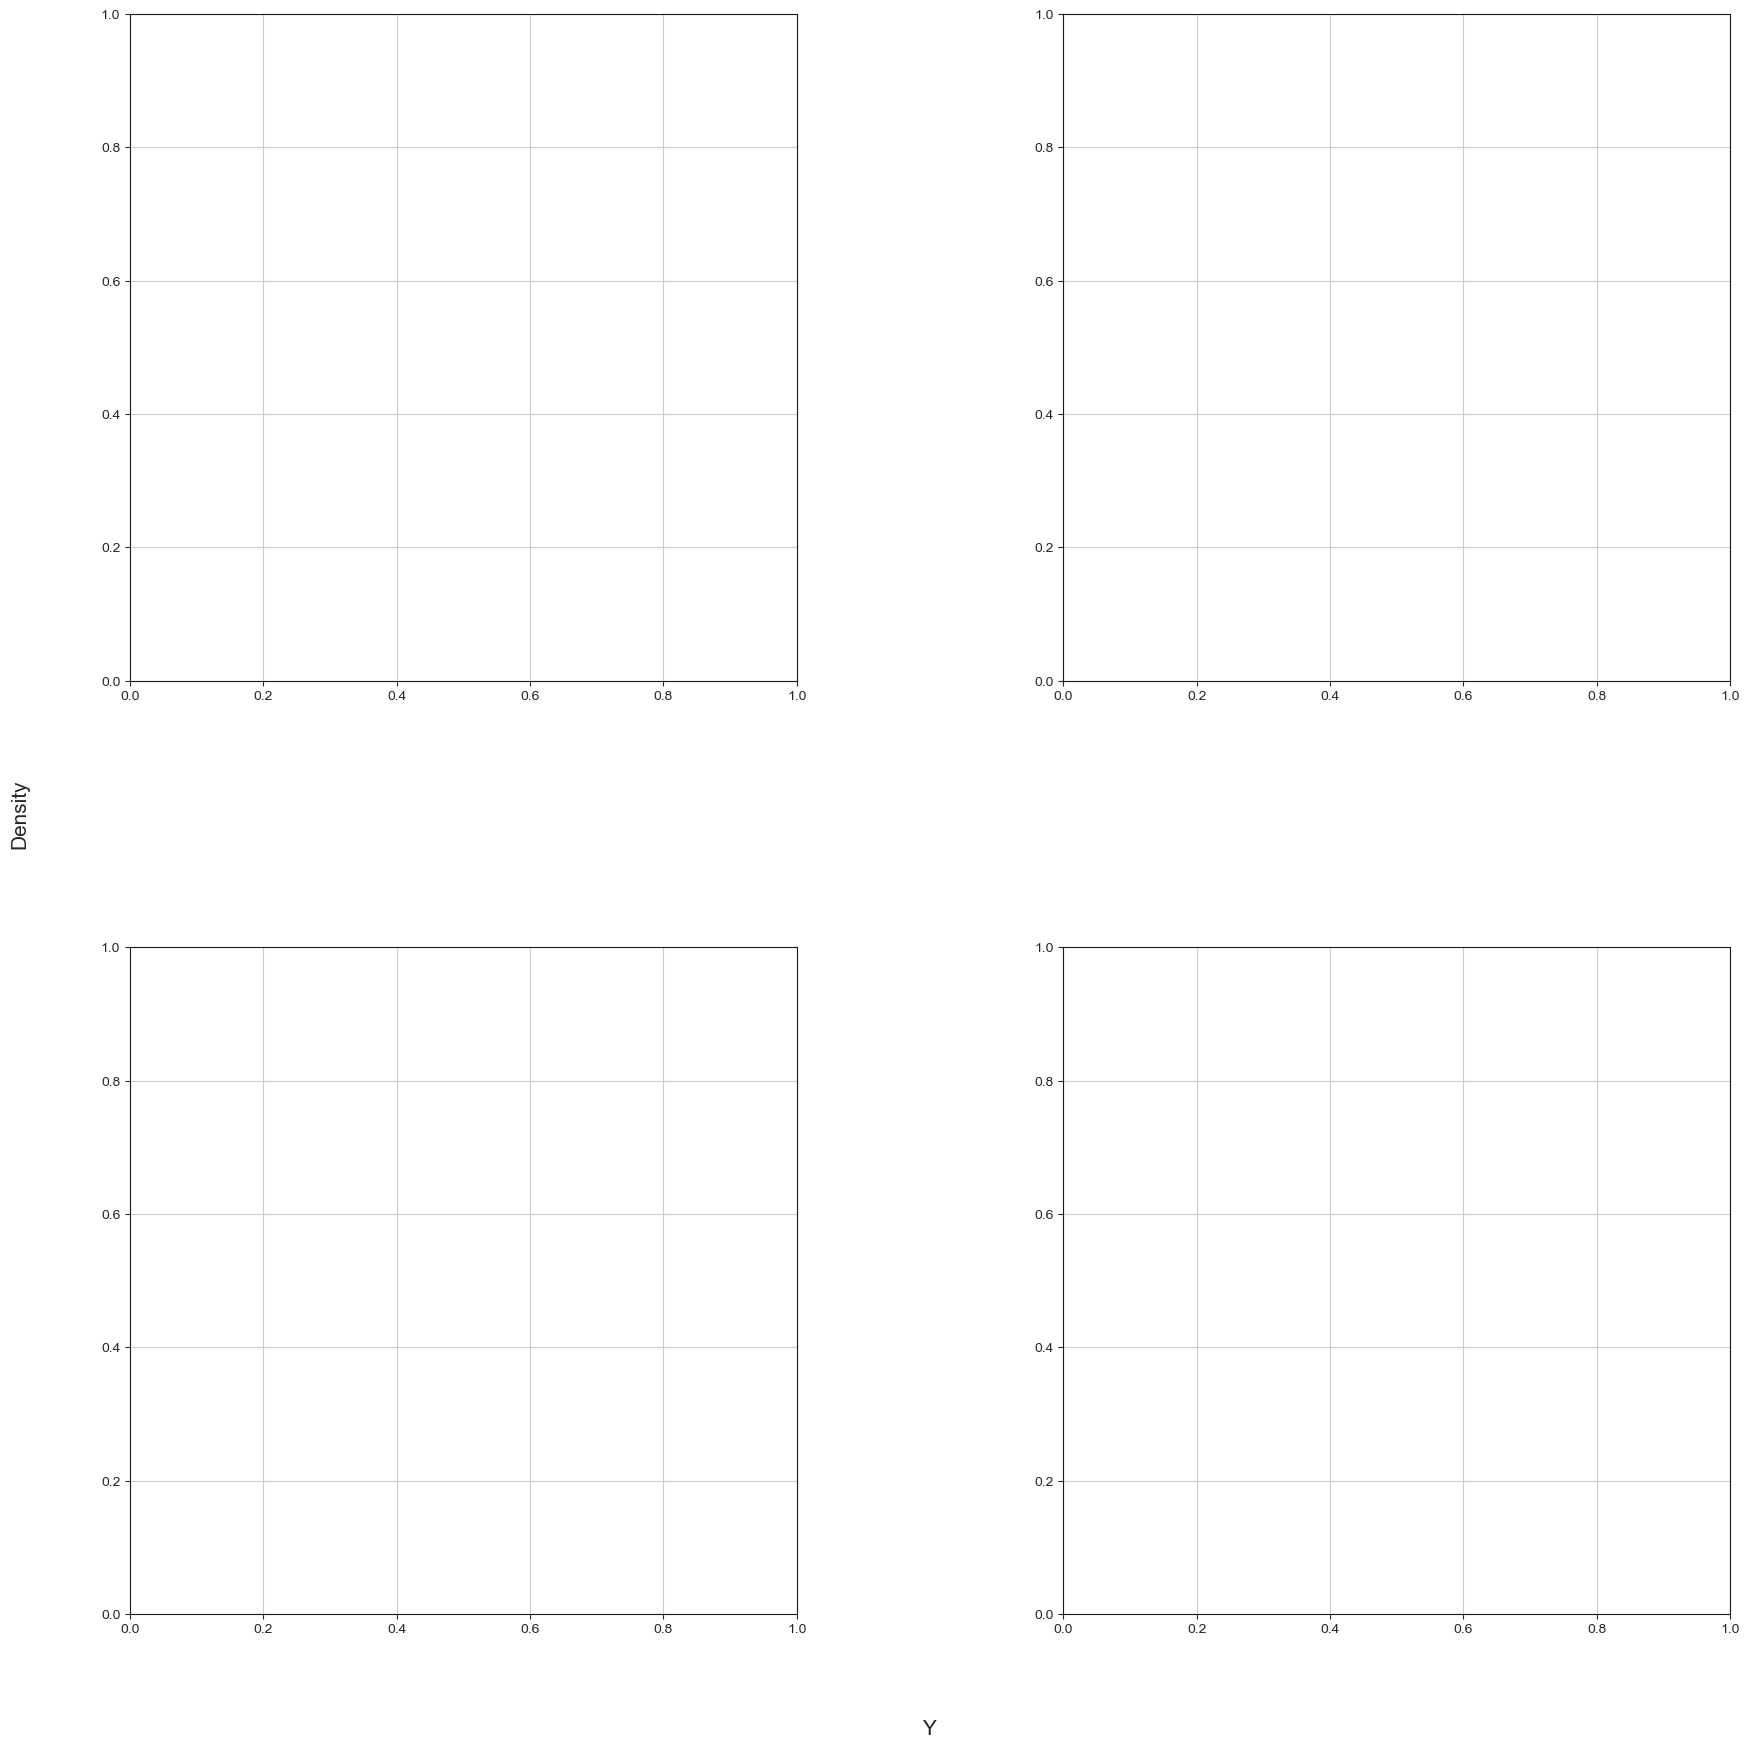

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.tight_layout()

plt.show()